In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import numpy as np
from scipy.stats import binom, norm
from scipy import integrate
from collections import namedtuple
from matplotlib import cm
import pandas as pd
import six
if six.PY3:
    from importlib import reload
import luigi
import pickle

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# k-NN

In [10]:
from empirical_privacy.one_bit_sum import ComputeOneBitKNNConvergence

from empirical_privacy import one_bit_sum_joblib as one_bit_sum
from empirical_privacy import lsdd
reload(one_bit_sum)

<module 'empirical_privacy.one_bit_sum_joblib' from '/emp_priv/src/empirical_privacy/one_bit_sum_joblib.py'>

In [6]:

def B_pmf(k, n, p):
    return binom(n, p).pmf(k)
def B0_pmf(k, n, p):
    return B_pmf(k, n-1, p)
def B1_pmf(k, n, p):
    return B_pmf(k-1, n-1, p)
def sd(N, P):
    return 0.5*np.sum(abs(B0_pmf(i, N, P) - B1_pmf(i, N, P)) for i in range(N+1))
def optimal_correctness(n, p):
    return 0.5 + 0.5*sd(n, p)

In [7]:
sd(40,0.5)

0.12537068761957668

In [5]:
one_bit_sum.get_density_est_correctness_rate_cached.clear()

In [13]:
n_max = 2**10
ntri=3
n=40
p=0.5

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.8s finished
/opt/conda/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.8s finished
/opt/conda/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be rem

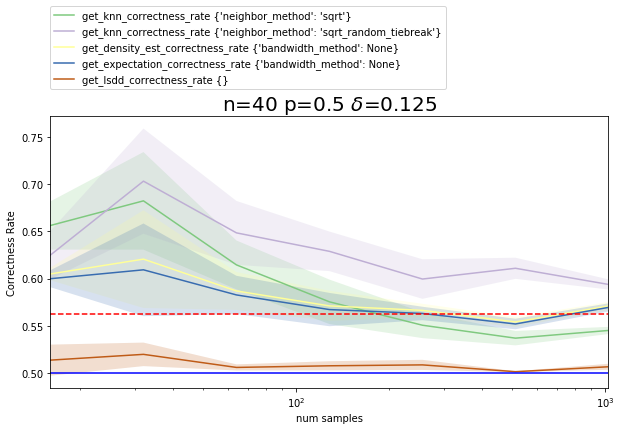

In [7]:
from math import ceil, log
one_bit_sum.n_jobs=1
N = int(ceil(log(n_max) / log(2)))
N_samples = np.logspace(4,N,num=N-3, base=2).astype(np.int)

ax = plt.figure(figsize=(10,5))
ax = plt.gca()
AlgArg = namedtuple('AlgArg', field_names=['f_handle', 'f_kwargs'])
algs = [
    AlgArg(one_bit_sum.get_knn_correctness_rate_cached, {'neighbor_method':'sqrt'}),
    AlgArg(one_bit_sum.get_knn_correctness_rate_cached, {'neighbor_method':'sqrt_random_tiebreak'}),

    AlgArg(one_bit_sum.get_density_est_correctness_rate_cached, {'bandwidth_method':None}),
    AlgArg(one_bit_sum.get_expectation_correctness_rate_cached, {'bandwidth_method':None}),
    AlgArg(one_bit_sum.get_lsdd_correctness_rate_cached, {})
    #AlgArg(one_bit_sum.get_knn_correctness_rate_cached, {'neighbor_method':'cv'})
]
colors = cm.Accent(np.linspace(0,1,len(algs)+1))
leg_handles = []
for (i,alg) in enumerate(algs):
    res = one_bit_sum.get_res(n,p,ntri, alg.f_handle, alg.f_kwargs, n_max=n_max)
    handle=sns.tsplot(res, ci='sd', color=colors[i], ax=ax, legend=False, time=N_samples)
#     f, coef = get_fit(res, N_samples)
#     print alg, coef
#     lim = coef[0]
#     plt.plot(N_samples, f(N_samples), linewidth=3)
#    plt.text(N_samples[-1], lim, '{:.3f}'.format(lim),fontsize=16)
j=0
for i in range(len(algs), 2*len(algs)):
    #print i, i/2-1 if i%2==0 else (i)/2
    handle.get_children()[i].set_label('{} {}'.format(algs[j].f_handle.func.__name__, algs[j].f_kwargs))
    j+=1
plt.semilogx()
plt.axhline(optimal_correctness(n, p), linestyle='--', color='r', label='_nolegend_')
plt.axhline(0.5, linestyle='-', color='b', label='_nolegend_')
plt.title('n={n} p={p} $\delta$={d:.3f}'.format(n=n, p=p, d=sd(n,p)), fontsize=20)
plt.xlabel('num samples')
plt.ylabel('Correctness Rate')
plt.legend(loc=(0,1.1))
#print ax.get_legend_handles_labels()

In [18]:
CC = ComputeOneBitKNNConvergence(
        n_trials_per_training_set_size=3,
        n_max=n_max,
        n_steps=4,
        dataset_settings = {
            'n_trials':ntri,
            'prob_success':p,
            'gen_distr_type':'binom'
        },
        validation_set_size = 1000
    )
luigi.build([CC], local_scheduler=True, workers=8, log_level='ERROR')
with CC.output().open() as f:
    res = pickle.load(f)
print(res['sd_matrix'])

[[ 0.757  0.757  0.757  0.757]
 [ 0.23   0.491  0.77   0.77 ]
 [ 0.605  0.605  0.731  0.731]]


In [8]:
def get_fit(res, N_samples):
    ntri, nsamp = res.shape
    sqrt2 = np.sqrt(2)
    Xlsq = np.hstack((np.ones((nsamp,1)),
                      sqrt2/(N_samples.astype(np.float)**0.25)[:, np.newaxis]))
    y = 1.0 - res.reshape((nsamp*ntri, 1))
    
    Xlsq = reduce(lambda x,y: np.vstack((x,y)), [Xlsq]*ntri)
    coef = np.linalg.lstsq(Xlsq, y)[0].ravel()
    f = lambda n: 1.0 - coef[0] - coef[1]*sqrt2/n.astype(np.float)**0.25, coef
    return f


In [15]:
trial=0
num_samples=2**11
bandwidth_method=None
from scipy.stats import gaussian_kde

X0, X1, y0, y1 = one_bit_sum.gen_data(n, p, num_samples, trial)
X0 = X0.ravel()
X1 = X1.ravel()
bw = None
if hasattr(bandwidth_method, '__call__'):
    bw = float(bandwidth_method(num_samples)) / num_samples  # eg log
if type(bandwidth_method) == float:
    bw = num_samples**(1-bandwidth_method)
f0 = gaussian_kde(X0, bw_method = bw)
f1 = gaussian_kde(X1, bw_method = bw)
#Omega = np.unique(np.concatenate((X0, X1)))
_min = 0
_max = n
x = np.linspace(_min, _max, num=10*num_samples)
print('difference of densities=',0.5 + 0.5 * 0.5 * np.mean(np.abs(f0(x)-f1(x))))
denom = f0(x)+f1(x)
numer = np.abs(f0(x)-f1(x))
print('expectation = ',0.5 + 0.5*np.mean(numer/denom))

difference of densities= 0.501463186537
expectation =  0.721647421333


# Uniforml distributed random variables

$$g_0 = U[0,0.5]+\sum_{i=1}^{n-1} U[0,1]$$

$$g_1 = U[0.5,1.0]+\sum_{i=1}^{n-1} U[0,1]$$

Let $\mu_n = \frac{n-1}{2}$ and $\sigma_n = \sqrt{\frac{n-0.75}{12}}$

By the CLT $g_0\sim N(\mu_n+0.25, \sigma_n)$ and $g_1\sim N(\mu_n+0.75, \sigma_n)$.

0.717188745214


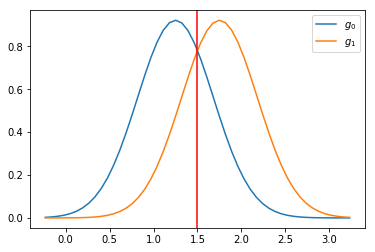

In [17]:
from math import sqrt
n=3
x = np.linspace(n/2.0-sqrt(n), n/2.0+sqrt(n))
sigma = sqrt((n-0.75)/12.0)
sqrt2 = sqrt(2)
mu = (n-1.0)/2

def g0_pdf(x):
    return norm.pdf(x, loc=mu+0.25, scale=sigma)
def g1_pdf(x):
    return norm.pdf(x, loc=mu+0.75, scale=sigma)
def d_pdf(x):
    return norm.pdf(x, loc=-0.5, scale=sigma*sqrt2)
def g_int(n):
    sigma = sqrt((n-0.75)/12.0)
    mu = (n-1.0)/2
    N0 = norm(loc=mu+0.25, scale=sigma)
    N1 = norm(loc=mu+0.75, scale=sigma)
    I0 = N0.cdf(n*0.5)-N0.cdf(0)
    I1 = N1.cdf(n*0.5)-N1.cdf(0)
    return 2*(I0-I1)
def g_stat_dist(n):
    return 0.5 * g_int(n)
def g_optimal_correctness(n):
    return 0.5 + 0.5*g_stat_dist(n)

plt.plot(x, g0_pdf(x), label='$g_0$')
plt.plot(x, g1_pdf(x), label='$g_1$')
#plt.plot(x, d_pdf(x), label='$d$')
plt.axvline(x=n/2.0, color='r')
assert g0_pdf(n/2.0)==g1_pdf(n/2.0)
plt.legend()
print(g_optimal_correctness(n))

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s finished
/opt/conda/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s finished
/opt/conda/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be rem

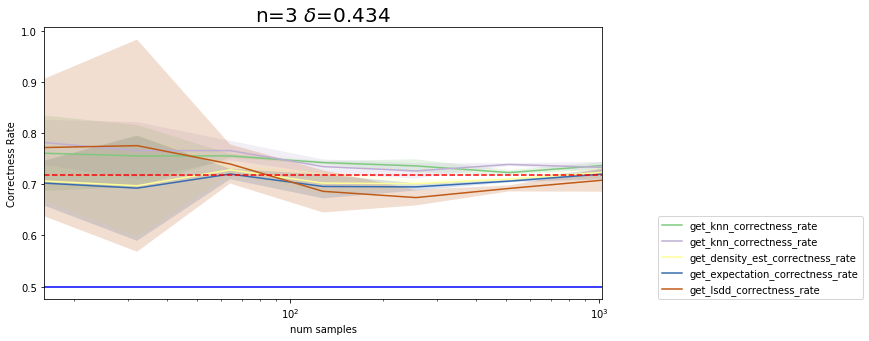

In [18]:
from math import ceil, log
if n_max >= 2**13:
    one_bit_sum.n_jobs=1
else:
    one_bit_sum.n_jobs=-1
    
N = int(ceil(log(n_max) / log(2)))
N_samples = np.logspace(4,N,num=N-3, base=2).astype(np.int)

ax = plt.figure(figsize=(10,5))
ax = plt.gca()
AlgArg = namedtuple('AlgArg', field_names=['f_handle', 'f_kwargs'])
algs = [
    AlgArg(one_bit_sum.get_knn_correctness_rate_cached, {'neighbor_method':'sqrt'}),
    AlgArg(one_bit_sum.get_knn_correctness_rate_cached, {'neighbor_method':'sqrt_random_tiebreak'}),

    AlgArg(one_bit_sum.get_density_est_correctness_rate_cached, {'bandwidth_method':None}),
    AlgArg(one_bit_sum.get_expectation_correctness_rate_cached, {'bandwidth_method':None}),
    AlgArg(one_bit_sum.get_lsdd_correctness_rate_cached, {})
    #AlgArg(one_bit_sum.get_knn_correctness_rate_cached, {'neighbor_method':'cv'})
]
for A in algs:
    A.f_kwargs['type']='norm'
colors = cm.Accent(np.linspace(0,1,len(algs)+1))
leg_handles = []
for (i,alg) in enumerate(algs):
    res = one_bit_sum.get_res(n,p,ntri, alg.f_handle, alg.f_kwargs, n_max=n_max)
    handle=sns.tsplot(res, ci='sd', color=colors[i], ax=ax, legend=False, time=N_samples)
#     f, coef = get_fit(res, N_samples)
#     print alg, coef
#     lim = coef[0]
#     plt.plot(N_samples, f(N_samples), linewidth=3)
#     plt.text(N_samples[-1], lim, '{:.3f}'.format(lim),fontsize=16)
j=0
for i in range(len(algs), 2*len(algs)):
    #print i, i/2-1 if i%2==0 else (i)/2
    handle.get_children()[i].set_label(algs[j].f_handle.func.__name__)
    j+=1
    #print handle.get_children()[i].get_label()
plt.semilogx()
plt.axhline(g_optimal_correctness(n), linestyle='--', color='r', label='_nolegend_')
plt.axhline(0.5, linestyle='-', color='b', label='_nolegend_')
plt.title('n={n} $\delta$={d:.3f}'.format(n=n, d=g_stat_dist(n)), fontsize=20)
plt.xlabel('num samples')
plt.ylabel('Correctness Rate')
plt.legend(loc=(1.1,0))
#print ax.get_legend_handles_labels()

In [19]:
true_value = g_optimal_correctness(n)
print(true_value)

0.717188745214


In [20]:
trial=0
num_samples=2**15
bandwidth_method=None
from scipy.stats import gaussian_kde

X0, X1, y0, y1 = one_bit_sum.gen_data(n, p, num_samples, trial, type='norm')
X0 = X0.ravel()
X1 = X1.ravel()
bw = None
if hasattr(bandwidth_method, '__call__'):
    bw = float(bandwidth_method(num_samples)) / num_samples  # eg log
if type(bandwidth_method) == float:
    bw = num_samples**(1-bandwidth_method)
f0 = gaussian_kde(X0, bw_method = bw)
f1 = gaussian_kde(X1, bw_method = bw)
#Omega = np.unique(np.concatenate((X0, X1)))
_min = 0
_max = n
x = np.linspace(_min, _max, num=num_samples)


In [22]:
print('difference of densities=',0.5 + 0.5 * 0.5 * integrate.quad(lambda x: np.abs(f0(x)-f1(x)), -np.inf, np.inf)[0])

difference of densities= 0.718765595870702


In [24]:
X = np.concatenate((X0,X1))
f0x = f0(X)
f1x = f1(X)
denom = (f0x+f1x+np.spacing(1))
numer = np.abs(f0x-f1x)
print('expectation = ',0.5 + 0.5*np.mean(numer/denom))

expectation =  0.717962665287


In [25]:
print('exact=',g_optimal_correctness(n))

exact= 0.717188745214


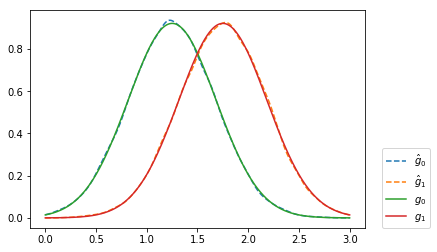

In [26]:
plt.plot(x, f0(x),label='$\hat g_0$', linestyle='--')
plt.plot(x, f1(x),label='$\hat g_1$', linestyle='--')
plt.plot(x, g0_pdf(x), label='$g_0$')
plt.plot(x, g1_pdf(x), label='$g_1$')
plt.legend(loc=(1.05,0))

### Comparing different numerical integration techniques

In [42]:
to_int = [f0,f1]

print 'Quad'
# for (i,f) in enumerate(to_int):
#     intr = integrate.quad(f, -np.inf, np.inf)
#     print 'func={0} err={1:.3e}'.format(i, abs(1-intr[0]))
g_int(n)-integrate.quad(lambda x: np.abs(f0(x)-f1(x)), -np.inf, np.inf)[0]

Quad


0.018350952521851926

In [58]:
to_int = [f0,f1]

print 'Quad'
g_int(n)-integrate.quad(lambda x: np.abs(f0(x)-f1(x)), -np.inf, np.inf)[0]

Quad


-0.006307402625538749

In [66]:
g_int(n)

0.8687549808572693

In [59]:
print 'Simps'
def delta(x):
    return np.abs(f0(x)-f1(x))
X = np.unique(np.concatenate((X0,X1)))
y = delta(X)
g_int(n)-integrate.simps(y,X)

Simps


-0.006304292280724488

In [62]:
import empirical_privacy.lsdd

In [65]:
rtv = lsdd.lsdd(X0[np.newaxis, :], X1[np.newaxis, :])

(array([14027.,  5980.,  4612.,  4045.,  3731.,  3626.,  4098.,  4858.,
         5973., 14586.]),
 array([-0.59502986, -0.47704484, -0.35905982, -0.2410748 , -0.12308979,
        -0.00510477,  0.11288025,  0.23086526,  0.34885028,  0.4668353 ,
         0.58482032]),
 <a list of 10 Patch objects>)

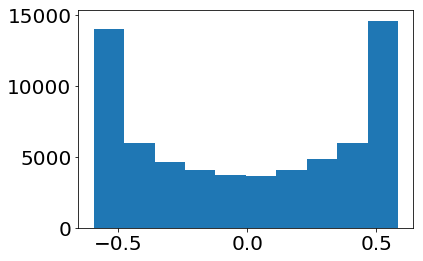

In [69]:
plt.hist(rtv[1])

In [70]:
np.mean(rtv[1])

0.000742328309077514

## Sympy-based analysis

In [ ]:
import sympy as sy
n,k = sy.symbols('n k', integer=True)
#k = sy.Integer(k)
p = sy.symbols('p', real=True)
q=1-p

def binom_pmf(k, n, p):
    return sy.binomial(n,k)*(p**k)*(q**(n-k))
def binom_cdf(x, n, p):
    return sy.Sum([binom_pmf(j, n, p) for j in sy.Range(x+1)])

B0 = binom_pmf(k, n-1, p)
B1 = binom_pmf(k-1, n-1, p)

In [ ]:
def stat_dist(N,P):
    return 0.5*sum([sy.Abs(B0.subs([(n,N),(p,P), (k,i)])-B1.subs([(n,N),(p,P), (k,i)])) for i in range(N+1)])
def sd(N, P):
    return 0.5*np.sum(abs(B0(i, N, P) - B1(i, N, P)) for i in range(N+1))

In [ ]:
stat_dist(50,0.5)

In [ ]:
sd(5000,0.5)

In [ ]:
N=2
terms =[(B0.subs([(n,N), (k,i)]).simplify(),B1.subs([(n,N), (k,i)]).simplify()) for i in range(N+1)]
print terms

In [ ]:
0.5*sum(map(lambda t: sy.Abs(t[0]-t[1]), terms)).subs([(p,0.5)])

In [ ]:
stat_dist(4,0.5)